In [7]:
import os
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import yaml
import glob
import seaborn as sns

# compare reads to mitochondria

In [8]:
proj_dir="/master/nplatt/sch_hae_its-nigeria"
results_dir=f"{proj_dir}/results"

In [9]:
#you can get this table from the SCAN dryad link
info_df=pd.read_csv(f"{proj_dir}/its-nigeria_samplesheet.csv", sep=",")
info_df

,wgs_id,its_id,sra,species,country,locale,patient,miracidum
0,Sb_NG_ak_1.1,Sb.ng.ak.1.1F,NaN,sbovis,nigeria,ak,1,1
1,Sb_NG_ak_2.1,sb_ng_ak_2.1,NaN,sbovis,nigeria,ak,2,1
2,Sb_NG_ak_2.2,Sb.ng.ak.2.2F,NaN,sbovis,nigeria,ak,2,2
3,Sb_NG_ak_2.3,Sb.ng.ak.2.3F,NaN,sbovis,nigeria,ak,2,3
4,Sb_NG_ak_3.1,Sb.ng.ak.3.1R,NaN,sbovis,nigeria,ak,3,1
...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,sh_ng_os_3_1,NaN,shaematobium,nigeria,osun,3,1
201,c_Sh_NG_os_3_11,Sh.ng.os.3.11F,NaN,shaematobium,nigeria,osun,3,11
202,c_Sh_NG_os_3_5,Sh.ng.os.3.5F,NaN,shaematobium,nigeria,osun,3,5
203,c_Sh_NG_os_3_6,Sh.ng.os.3.6F,NaN,shaematobium,nigeria,osun,3,6


In [10]:
Path(f"{results_dir}/mito_read_count").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/mito_read_count")

In [11]:
info_df["wgs_id"].to_csv("samples.list", sep=",", header=False, index=False)

In [12]:
%%bash

mkdir -p reference_mitochondria logs

cp /master/nplatt/sch_hae_nigeria/data/sha_angola_cota_58_mito.fas reference_mitochondria/

echo """OX103960.1
OX104030.1
OX103896.1
OX336422.1
OX103731.1
OX104147.1
OX103949.1""">mito_accessions.txt

In [ ]:
%%bash 

conda activate entrez

cat /master/nplatt/sch_hae_its-nigeria/data/sha_angola_cota_58_mito.fas >reference_mitochondria.fasta

cat mito_accessions.txt \
    | xargs -n 1 -I {} sh -c "efetch -db nucleotide -id {} -format fasta >> reference_mitochondria.fasta"

sed 's/ /_/1; s/ /_/1' reference_mitochondria.fasta \
    | cut -f1 -d" " \
    | sed 's/Schistosoma_/S/g' \
    | sed 's/sha_angola_cota_58/XXXXXXXX.X_Shaematobium/' \
    >reference_mitochondria.fasta.renamed

mv reference_mitochondria.fasta.renamed reference_mitochondria.fasta

In [21]:
%%bash

conda run -n clustal --live-stream clustalo \
    -i reference_mitochondria.fasta \
    -o reference_mitochondria.aligned-r1.fasta \
    --threads=12

In [ ]:
# manually trim (focusing on the ends of the alignment)

In [22]:
%%bash 

conda run -n clustal --live-stream clustalo \
    -i reference_mitochondria.trimmed-r1.fasta \
    -o reference_mitochondria.aligned-r2.fasta \
    --threads=12

In [ ]:
# manually verified the alignment

In [ ]:
%%bash 

sed 's/-//g' reference_mitochondria.aligned-r2.fasta | seqtk seq -l80 >reference_mitochondria.final.fasta

In [33]:
%%bash 

# Project and results directories
PROJ_DIR="/master/nplatt/sch_hae_its-nigeria"
RESULTS_DIR="$PROJ_DIR/results"

set -euo pipefail

# Make sure the output directory exists
mkdir -p "$RESULTS_DIR/mito_read_count"
cd "$RESULTS_DIR/mito_read_count"

# Loop through each sample in the samples.list file
while read -r SAMPLE; do
    # Inputs
    FQ1="$RESULTS_DIR/filtered_reads/${SAMPLE}_filtered_R1.fq.gz"
    FQ2="$RESULTS_DIR/filtered_reads/${SAMPLE}_filtered_R2.fq.gz"
    REF="reference_mitochondria.final.fasta"

    # Outputs
    OUT_DIR="$RESULTS_DIR/mito_read_count"
    MAP_SAM="$OUT_DIR/$SAMPLE.ambig-all.bbmap.sam"                    # SAM from bbmap
    SORTED_BAM="$OUT_DIR/$SAMPLE.ambig-all.bbmap.sorted.bam"
    TARGET_BAM="$OUT_DIR/$SAMPLE.ambig-all.bbmap.mitotarget.bam"
    TARGET_RANDOM_ORDER_BAM="$OUT_DIR/$SAMPLE.ambig-all.bbmap.mitotarget.randomized.bam"
    MAPPED_FQ="$OUT_DIR/$SAMPLE.ambig-all.mapped.fq"
    COUNTS_FILE="$OUT_DIR/$SAMPLE.ambig-all.mito_counts.csv"
    LOG_FILE="$OUT_DIR/$SAMPLE.ambig-all.bbmap"
    SCRIPT_FILE="$OUT_DIR/$SAMPLE.ambig-all.mito_pipeline.sh"

    # Sanity checks
    if [[ ! -f "$FQ1" || ! -f "$FQ2" ]]; then
        echo "Missing input files for $SAMPLE. Skipping..."
        continue
    fi

    # Create the SGE script
    cat > "$SCRIPT_FILE" <<'EOS'
#!/bin/bash
#$ -cwd
#$ -V
#$ -S /bin/bash
#$ -N mito_bbmap___SAMPLE___
#$ -o ___LOG_FILE___.stdout
#$ -j y
#$ -q all.q
#$ -pe smp 12

set -euo pipefail

echo "Step 1: Map reads to the reference mitochondrial sequences"
conda run -n bbmap --live-stream bbmap.sh \
  ref=___REF___ \
  nodisk \
  in=___FQ1___ \
  in2=___FQ2___ \
  threads=12 \
  ambig=all \
  interleaved=f \
  -Xmx64g \
  eoom \
  out=___MAP_SAM___ \
  minid=0.80

echo "Step 2: Convert mapped SAM to sorted BAM (keep only mapped reads)"
conda run -n samtools bash -c '
  samtools view -h -F 4 -S ___MAP_SAM___ \
  | samtools sort -@ 12 -o ___SORTED_BAM___ -
'

echo "Step 3: Index the sorted BAM"
conda run -n samtools --live-stream samtools index ___SORTED_BAM___

echo "Step 4: Count reads per reference sequence"
conda run -n samtools --live-stream samtools view -F 4 ___SORTED_BAM___ \
  | cut -f3 \
  | sort \
  | uniq -c \
  | awk 'BEGIN {print "ref,count"} {print $2 "," $1}' > ___COUNTS_FILE___

echo "Step 5: Compute genome coverage with mosdepth"
conda run -n mosdepth mosdepth -t 4 ___SAMPLE___ ___SORTED_BAM___

echo "Step 6: Select the contig with the highest mean depth"
CONTIG=$(awk 'NR>1 && $4>max {max=$4;chrom=$1} END{print chrom}' ___SAMPLE___.mosdepth.summary.txt)

echo "Step 6b: Extract reads from the top contig into a target BAM"
conda run -n samtools samtools view -h -b -o ___TARGET_BAM___ ___SORTED_BAM___ "$CONTIG"

echo "Step 7: Randomize read order"
conda run -n samtools samtools collate -o ___TARGET_RANDOM_ORDER_BAM___ ___TARGET_BAM___

echo "Step 8: Extract mapped reads to FASTQ"
conda run -n bedtools bedtools bamtofastq -i ___TARGET_RANDOM_ORDER_BAM___ -fq ___MAPPED_FQ___

echo "Step 9: Compress mapped reads"
gzip -f ___MAPPED_FQ___

echo "Done."
EOS

    # Fill in placeholders safely
    sed -i \
      -e "s|___SAMPLE___|$SAMPLE|g" \
      -e "s|___LOG_FILE___|$LOG_FILE|g" \
      -e "s|___REF___|$REF|g" \
      -e "s|___FQ1___|$FQ1|g" \
      -e "s|___FQ2___|$FQ2|g" \
      -e "s|___MAP_SAM___|$MAP_SAM|g" \
      -e "s|___SORTED_BAM___|$SORTED_BAM|g" \
      -e "s|___COUNTS_FILE___|$COUNTS_FILE|g" \
      -e "s|___TARGET_BAM___|$TARGET_BAM|g" \
      -e "s|___TARGET_RANDOM_ORDER_BAM___|$TARGET_RANDOM_ORDER_BAM|g" \
      -e "s|___MAPPED_FQ___|$MAPPED_FQ|g" \
      "$SCRIPT_FILE"

    chmod +x "$SCRIPT_FILE"

    # Submit the SGE script
    qsub "$SCRIPT_FILE"

done < samples.list


Your job 1658759 ("mito_bbmapc_Sh_NG_bo_1_3") has been submitted
Your job 1658760 ("mito_bbmapc_Sh_NG_bo_3_1") has been submitted
Your job 1658761 ("mito_bbmapc_Sh_NG_bo_3_2") has been submitted
Your job 1658762 ("mito_bbmapc_Sh_NG_bo_4_1") has been submitted
Your job 1658763 ("mito_bbmapc_Sh_NG_bo_5_1") has been submitted
Your job 1658764 ("mito_bbmapc_Sh_NG_bo_5_2") has been submitted
Your job 1658765 ("mito_bbmapc_Sh_NG_bo_5_4") has been submitted
Your job 1658766 ("mito_bbmapc_Sh_NG_bo_5_5") has been submitted
Your job 1658767 ("mito_bbmapc_Sh_NG_bo_6_1") has been submitted
Your job 1658768 ("mito_bbmapc_Sh_NG_bo_6_2") has been submitted
Your job 1658769 ("mito_bbmapc_Sh_NG_bo_7_1") has been submitted
Your job 1658770 ("mito_bbmapc_Sh_NG_bo_7_2") has been submitted
Your job 1658771 ("mito_bbmapc_Sh_NG_bo_7_3") has been submitted
Your job 1658772 ("mito_bbmapc_Sh_NG_eb_1_3") has been submitted
Your job 1658773 ("mito_bbmapc_Sh_NG_eb_2_2") has been submitted
Your job 1658774 ("mito_b

In [13]:
accessions = { "OX103960.1_Sbovis"         : "s_bovis",
               "OX104030.1_Smargrebowiei"  : "s_margrebowiei",
               "OX103896.1_Sguineensis"    : "s_guineensis",
               "OX336422.1_Sspindale"      : "s_spindale",
               "OX103731.1_Sintercalatum"  : "s_intercalatum",
               "OX104147.1_Scurassoni"     : "s_curassoni",
               "OX103949.1_Smattheei"      : "s_mattheei",
               "XXXXXXXX.X_Shaematobium"   : "s_haematobium"}

In [14]:
info_df

,wgs_id,its_id,sra,species,country,locale,patient,miracidum
0,Sb_NG_ak_1.1,Sb.ng.ak.1.1F,NaN,sbovis,nigeria,ak,1,1
1,Sb_NG_ak_2.1,sb_ng_ak_2.1,NaN,sbovis,nigeria,ak,2,1
2,Sb_NG_ak_2.2,Sb.ng.ak.2.2F,NaN,sbovis,nigeria,ak,2,2
3,Sb_NG_ak_2.3,Sb.ng.ak.2.3F,NaN,sbovis,nigeria,ak,2,3
4,Sb_NG_ak_3.1,Sb.ng.ak.3.1R,NaN,sbovis,nigeria,ak,3,1
...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,sh_ng_os_3_1,NaN,shaematobium,nigeria,osun,3,1
201,c_Sh_NG_os_3_11,Sh.ng.os.3.11F,NaN,shaematobium,nigeria,osun,3,11
202,c_Sh_NG_os_3_5,Sh.ng.os.3.5F,NaN,shaematobium,nigeria,osun,3,5
203,c_Sh_NG_os_3_6,Sh.ng.os.3.6F,NaN,shaematobium,nigeria,osun,3,6


In [15]:
# Gather all files matching the pattern

# Initialize an empty DataFrame for the consolidated data
consolidated_df = pd.DataFrame()

# Process each file
for index, row in info_df.iterrows():
    
    sample = row["wgs_id"]
    file=f"{sample}.ambig-all.mito_counts.csv"
    
    # Read the CSV file (assuming no headers and it's separated by commas)
    df = pd.read_csv(file, header=0)
    
    # Pivot the DataFrame
    df = df.set_index('ref').T
    
    # Add a sample identifier column
    df['sample_id'] = sample
    
    # Append to the consolidated DataFrame
    if consolidated_df.empty:
        consolidated_df = df
    else:
        consolidated_df = pd.concat([consolidated_df, df], ignore_index=True)

# Reorder columns to have sample_id first
consolidated_df = consolidated_df[['sample_id'] + [col for col in consolidated_df.columns if col != 'sample_id']]

#rename columns to ref species:
consolidated_df = consolidated_df.rename(columns=accessions)

# Basic house cleaning
consolidated_df = consolidated_df.fillna(0)
consolidated_df = consolidated_df.reset_index(drop=True)

# Count number of mapped reads per sample
consolidated_df['num_mito_reads'] = consolidated_df[list(accessions.values())].sum(axis=1)

# Save the consolidated DataFrame to a new CSV file
consolidated_df.to_csv("mito_counts.csv", sep=",", header=True, index=False)
consolidated_df

ref,sample_id,s_intercalatum,s_guineensis,s_mattheei,s_bovis,s_margrebowiei,s_curassoni,s_spindale,s_haematobium,num_mito_reads
0,Sb_NG_ak_1.1,789,7010,285,138219,49,8045,51,99,154547
1,Sb_NG_ak_2.1,808,6530,313,101157,51,6276,44,116,115295
2,Sb_NG_ak_2.2,1022,14624,453,244206,65,13790,53,162,274375
3,Sb_NG_ak_2.3,919,4837,209,97761,27,6068,28,78,109927
4,Sb_NG_ak_3.1,834,9611,328,231388,63,10569,32,148,252973
...,...,...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,1752,317,467,555,74,335,107,56771,60378
201,c_Sh_NG_os_3_11,113,20,40,34,3,13,5,5566,5794
202,c_Sh_NG_os_3_5,331,54,72,105,24,67,29,16151,16833
203,c_Sh_NG_os_3_6,341,72,157,82,24,82,36,47037,47831


In [16]:
normalized_df = consolidated_df.copy()
columns_to_normalize = [col for col in consolidated_df.columns if col not in ['sample_id', 'num_mito_reads']]

normalized_df[columns_to_normalize] = normalized_df[columns_to_normalize].div(normalized_df['num_mito_reads'], axis=0)

# Drop the num_mito_reads column from the normalized DataFrame if not needed
normalized_df = normalized_df.drop(columns=['num_mito_reads'])
normalized_df.to_csv("normalized_mito_counts.csv", sep=",", header=True, index=False)
normalized_df

ref,sample_id,s_intercalatum,s_guineensis,s_mattheei,s_bovis,s_margrebowiei,s_curassoni,s_spindale,s_haematobium
0,Sb_NG_ak_1.1,0.005105,0.045358,0.001844,0.894349,0.000317,0.052055,0.000330,0.000641
1,Sb_NG_ak_2.1,0.007008,0.056637,0.002715,0.877375,0.000442,0.054434,0.000382,0.001006
2,Sb_NG_ak_2.2,0.003725,0.053299,0.001651,0.890045,0.000237,0.050260,0.000193,0.000590
3,Sb_NG_ak_2.3,0.008360,0.044002,0.001901,0.889327,0.000246,0.055200,0.000255,0.000710
4,Sb_NG_ak_3.1,0.003297,0.037992,0.001297,0.914675,0.000249,0.041779,0.000126,0.000585
...,...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,0.029017,0.005250,0.007735,0.009192,0.001226,0.005548,0.001772,0.940260
201,c_Sh_NG_os_3_11,0.019503,0.003452,0.006904,0.005868,0.000518,0.002244,0.000863,0.960649
202,c_Sh_NG_os_3_5,0.019664,0.003208,0.004277,0.006238,0.001426,0.003980,0.001723,0.959484
203,c_Sh_NG_os_3_6,0.007129,0.001505,0.003282,0.001714,0.000502,0.001714,0.000753,0.983400


In [17]:
import pandas as pd
from scipy.stats import binomtest

# columns holding per-genome read counts
genome_cols = [
    "s_intercalatum","s_guineensis","s_mattheei","s_bovis",
    "s_margrebowiei","s_curassoni","s_spindale","s_haematobium"
]

def runnerup_confidence(row):
    N = int(row["num_mito_reads"])
    counts = row[genome_cols].astype(int).sort_values(ascending=False)
    top, runner_up = counts.index[0], counts.index[1]
    top_count, runner_count = int(counts.iloc[0]), int(counts.iloc[1])

    n_top2 = top_count + runner_count
    # Binomial test: H0 p=0.5 vs HA p>0.5 (top beats runner-up)
    pval_runner = binomtest(top_count, n_top2, p=0.5, alternative="greater").pvalue

    return pd.Series({
        "top_genome": top,
        "runner_up": runner_up,
        "top_count": top_count,
        "runner_count": runner_count,
        "total_reads": N,
        "top_fraction": top_count / N if N > 0 else float("nan"),
        "binom_pval_runner": pval_runner,
    })

# Apply to your consolidated_df
results = consolidated_df.apply(runnerup_confidence, axis=1)
mito_confidence_df = pd.concat([consolidated_df[["sample_id"]], results], axis=1)

# Tag anything that FAILS the thresholds:
#   - p-value >= 0.01  (not significant)
#   - total reads < 10,000
# If you meant to tag when p-value < 0.01, flip the comparison below.
mito_confidence_df["flag"] = (
    (mito_confidence_df["binom_pval_runner"] >= 0.01) | (mito_confidence_df["total_reads"] < 1_000)
).map({True: "REVIEW", False: "OK"})

# Optional: sort to see the most concerning first
mito_confidence_df = mito_confidence_df.sort_values(["flag", "binom_pval_runner"], ascending=[False, True])

mito_confidence_df.to_csv("mito_confidence.csv", sep=",", header=True, index=False)

mito_confidence_df

,sample_id,top_genome,runner_up,top_count,runner_count,total_reads,top_fraction,binom_pval_runner,flag
0,Sb_NG_ak_1.1,s_bovis,s_curassoni,138219,8045,154547,0.894349,0.0,OK
1,Sb_NG_ak_2.1,s_bovis,s_guineensis,101157,6530,115295,0.877375,0.0,OK
2,Sb_NG_ak_2.2,s_bovis,s_guineensis,244206,14624,274375,0.890045,0.0,OK
3,Sb_NG_ak_2.3,s_bovis,s_curassoni,97761,6068,109927,0.889327,0.0,OK
4,Sb_NG_ak_3.1,s_bovis,s_curassoni,231388,10569,252973,0.914675,0.0,OK
...,...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,s_haematobium,s_intercalatum,56771,1752,60378,0.940260,0.0,OK
201,c_Sh_NG_os_3_11,s_haematobium,s_intercalatum,5566,113,5794,0.960649,0.0,OK
202,c_Sh_NG_os_3_5,s_haematobium,s_intercalatum,16151,331,16833,0.959484,0.0,OK
203,c_Sh_NG_os_3_6,s_haematobium,s_intercalatum,47037,341,47831,0.983400,0.0,OK


In [25]:
mito_confidence_df.loc[mito_confidence_df["flag"] != "OK"]

,sample_id,top_genome,runner_up,top_count,runner_count,total_reads,top_fraction,binom_pval_runner,flag


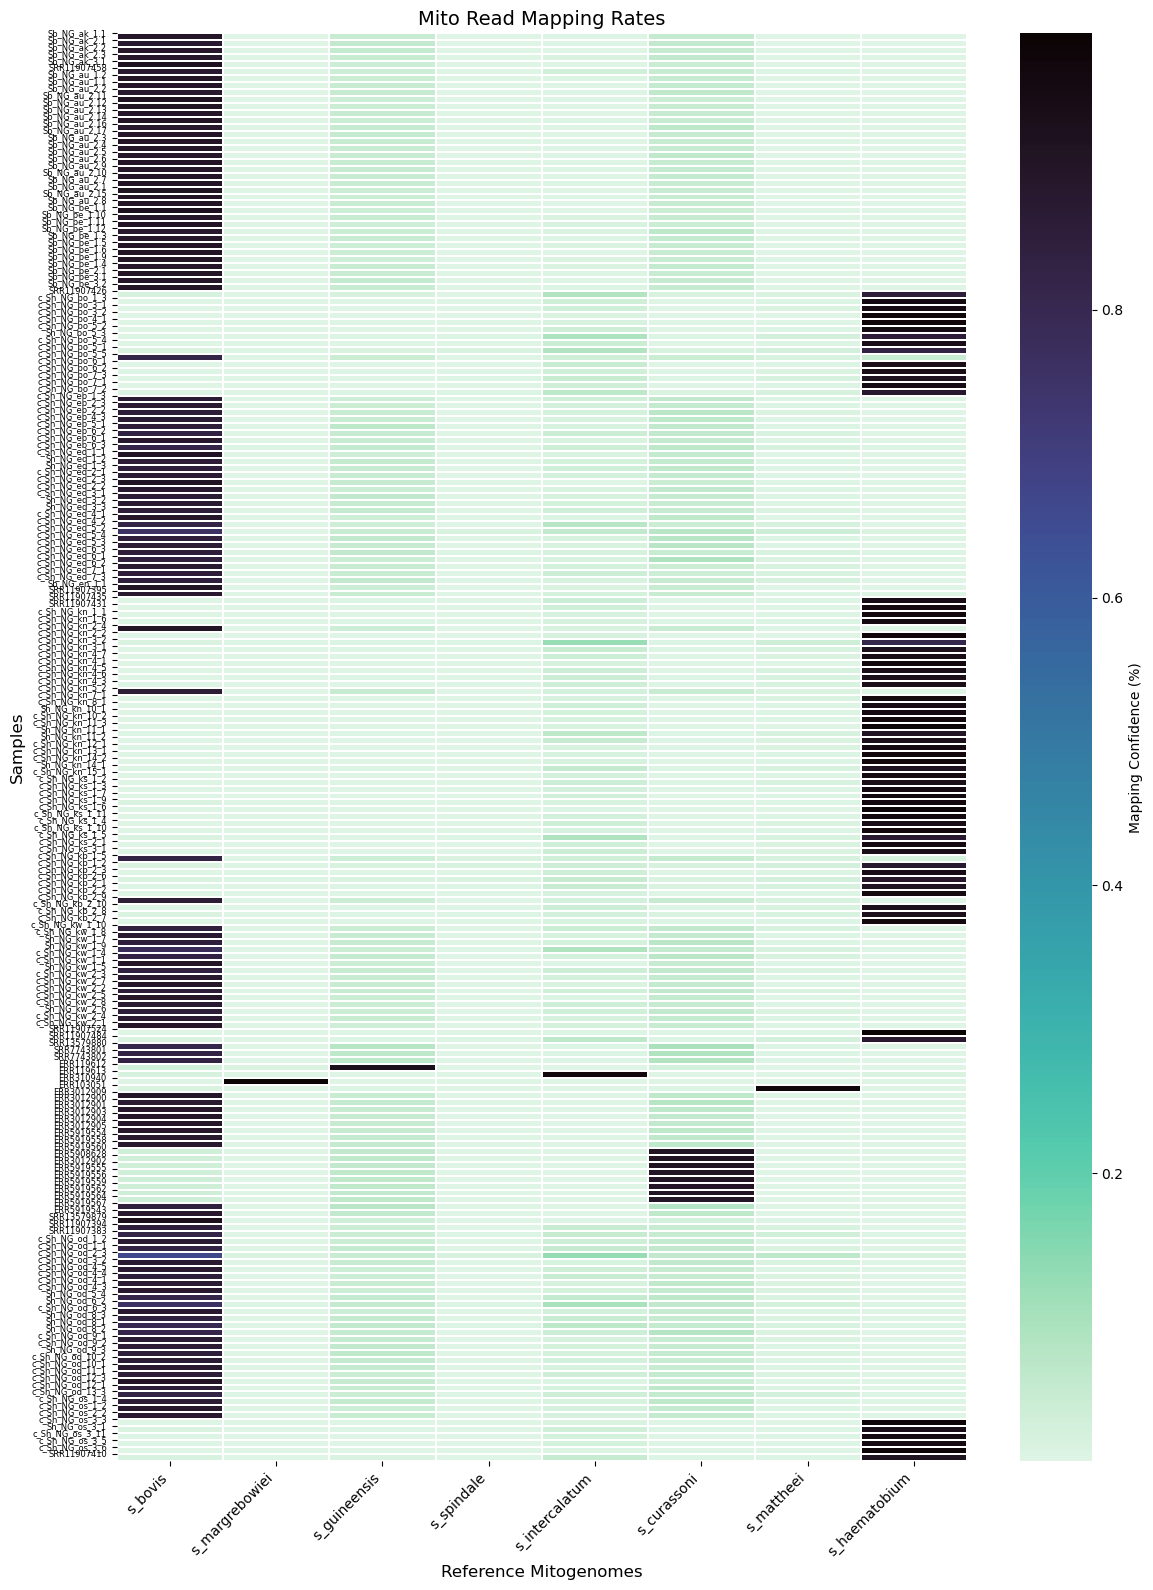

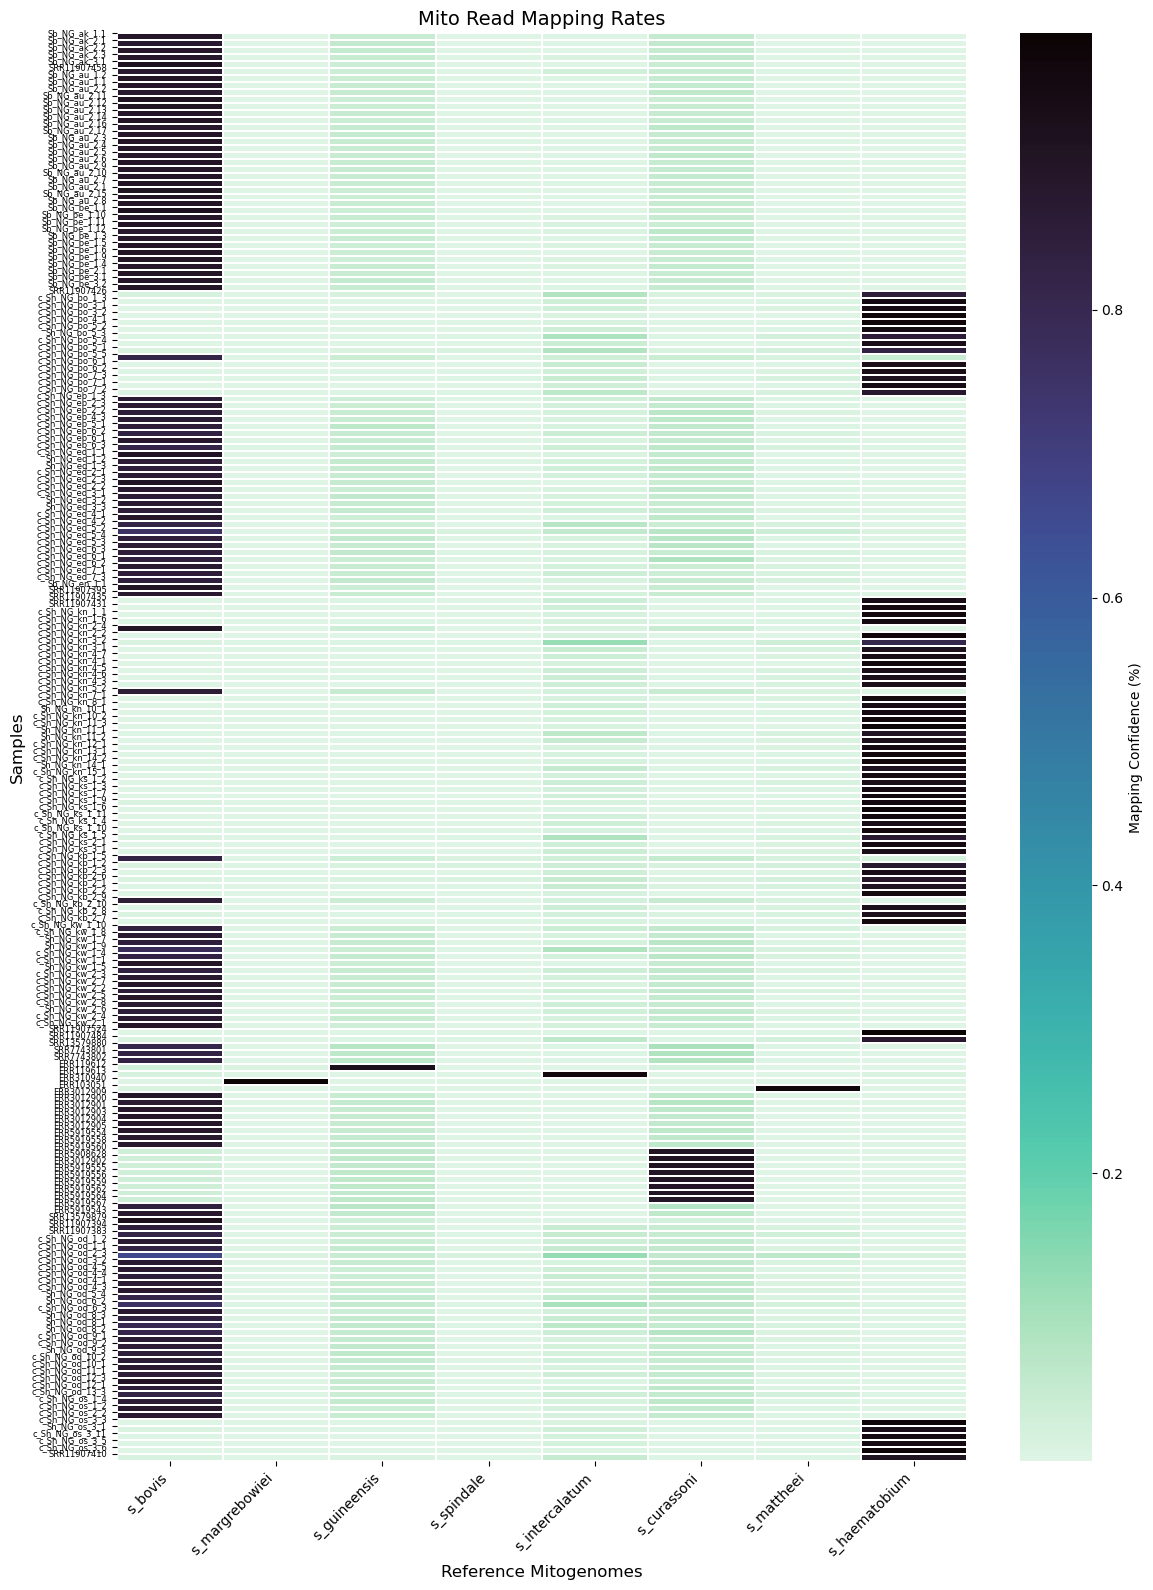

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 16))  # Adjust the figure size to better accommodate 209 rows

# Draw the heatmap
ax = sns.heatmap(
    normalized_df[list(accessions.values())], 
    annot=False,  # Disable annotations for clarity with 209 rows
    fmt=".3f", 
    linewidths=.1, 
    cmap='mako_r', 
    cbar_kws={'label': 'Mapping Confidence (%)'}  # Add a label to the color bar
)

# Set the y-axis labels explicitly to match the number of rows
ax.set_yticks(range(len(normalized_df)))  # Set y-ticks to the correct number of rows
ax.set_yticklabels(normalized_df["sample_id"], rotation=0, fontsize=6)  # Reduce font size for readability

# Adjust the x-axis labels
ax.set_xticklabels(list(accessions.values()), rotation=45, horizontalalignment='right')

# Add labels and title
plt.title('Mito Read Mapping Rates', fontsize=14)
plt.xlabel('Reference Mitogenomes', fontsize=12)
plt.ylabel('Samples', fontsize=12)

# Optional: Save the plot
# plt.savefig('mito_mapping_rate_heatmap.png', facecolor="white", dpi=600, bbox_inches='tight')
# plt.savefig('mito_mapping_rate_heatmap.svg')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [22]:
consolidated_df.to_csv("mito_counts.csv", sep=",", header=True, index=False)
consolidated_df

ref,sample_id,s_intercalatum,s_guineensis,s_mattheei,s_bovis,s_margrebowiei,s_curassoni,s_spindale,s_haematobium,num_mito_reads
0,Sb_NG_ak_1.1,789,7010,285,138219,49,8045,51,99,154547
1,Sb_NG_ak_2.1,808,6530,313,101157,51,6276,44,116,115295
2,Sb_NG_ak_2.2,1022,14624,453,244206,65,13790,53,162,274375
3,Sb_NG_ak_2.3,919,4837,209,97761,27,6068,28,78,109927
4,Sb_NG_ak_3.1,834,9611,328,231388,63,10569,32,148,252973
...,...,...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,1752,317,467,555,74,335,107,56771,60378
201,c_Sh_NG_os_3_11,113,20,40,34,3,13,5,5566,5794
202,c_Sh_NG_os_3_5,331,54,72,105,24,67,29,16151,16833
203,c_Sh_NG_os_3_6,341,72,157,82,24,82,36,47037,47831


In [38]:
normalized_df = normalized_df.merge(
    info_df[["wgs_id", "species", "country", "locale"]],
    how="inner",
    right_on="wgs_id",
    left_on="sample_id"
)
normalized_df.to_csv("normalized_mito_counts.csv", sep=",", header=True, index=False)


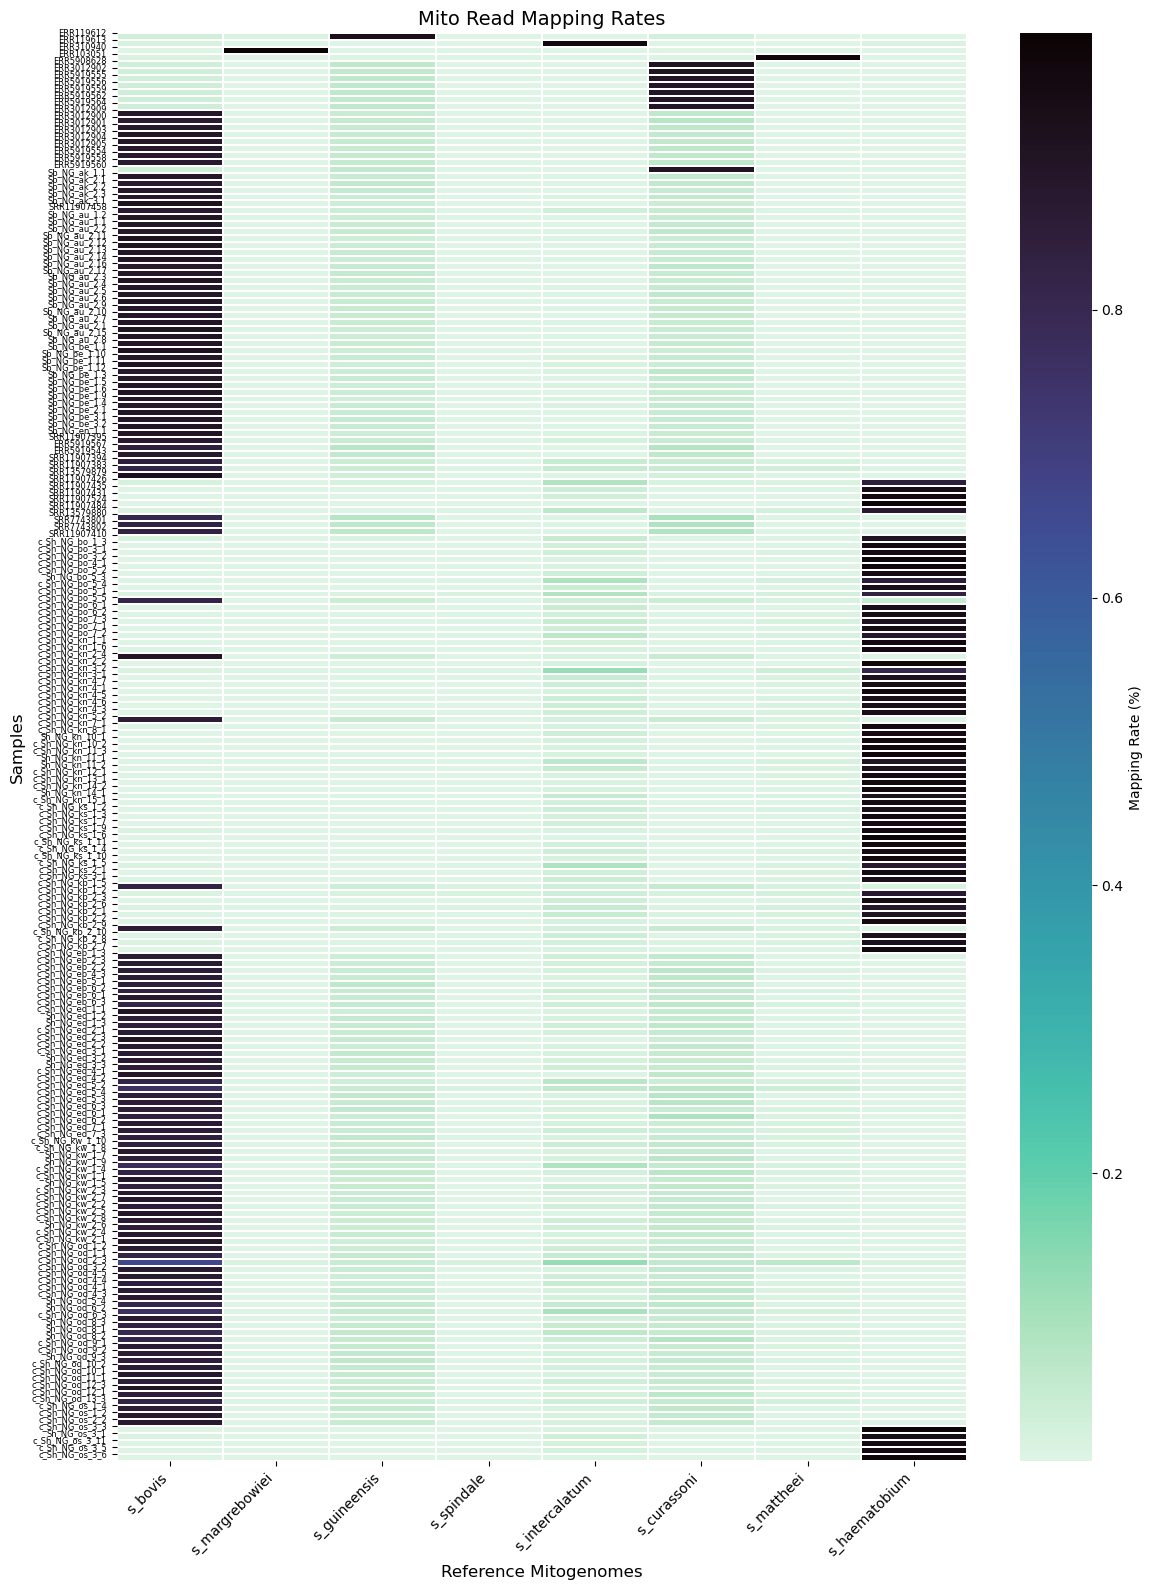

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 16))  # Adjust the figure size to better accommodate 209 rows

normalized_df=pd.read_csv("normalized_mito_counts.mod.csv", sep=",", header=0)

# Draw the heatmap
ax = sns.heatmap(
    normalized_df[list(accessions.values())], 
    annot=False,  # Disable annotations for clarity with 209 rows
    fmt=".3f", 
    linewidths=.1, 
    cmap='mako_r', 
    cbar_kws={'label': 'Mapping Rate (%)'}  # Add a label to the color bar
)

# Set the y-axis labels explicitly to match the number of rows
ax.set_yticks(range(len(normalized_df)))  # Set y-ticks to the correct number of rows
ax.set_yticklabels(normalized_df["sample_id"], rotation=0, fontsize=6)  # Reduce font size for readability

# Adjust the x-axis labels
ax.set_xticklabels(list(accessions.values()), rotation=45, horizontalalignment='right')

# Add labels and title
plt.title('Mito Read Mapping Rates', fontsize=14)
plt.xlabel('Reference Mitogenomes', fontsize=12)
plt.ylabel('Samples', fontsize=12)

# Optional: Save the plot
# plt.savefig('mito_mapping_rate_heatmap.png', facecolor="white", dpi=600, bbox_inches='tight')
# plt.savefig('mito_mapping_rate_heatmap.svg')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


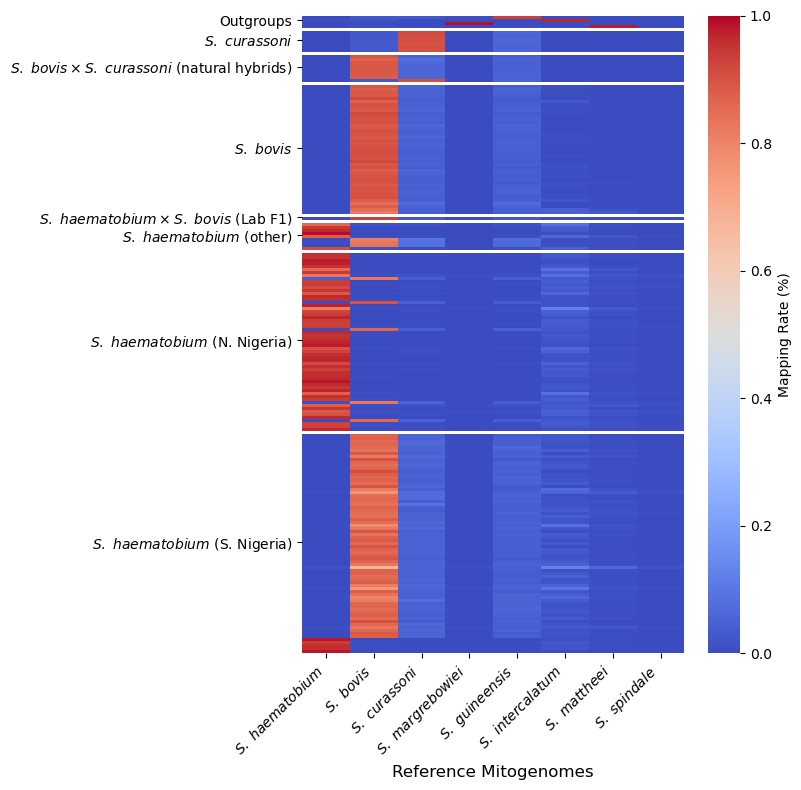

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Config
# -------------------
csv_path = "normalized_mito_counts.mod.csv"
gap_rows = 1                     # number of blank rows between groups
x_tick_fontsize = 10
y_tick_fontsize = 10

# Desired column order on the X-axis (use any order you like)
custom_order = [
    "s_haematobium",
    "s_bovis",
    "s_curassoni",
    "s_margrebowiei",
    "s_guineensis",
    "s_intercalatum",
    "s_mattheei",
    "s_spindale",

]

# Y-axis (group) display labels
group_label_map = {
    "outgroup": "Outgroups",
    "scurassoni": r"$\it{S.\ curassoni}$",
    "sbovis": r"$\it{S.\ bovis}$",
    "sbxsc": r"$\it{S.\ bovis}\times\it{S.\ curassoni}$ (natural hybrids)",
    "shxsb": r"$\it{S.\ haematobium}\times\it{S.\ bovis}$ (Lab F1)",
    "shaematobium": r"$\it{S.\ haematobium}$ (other)",
    "sh-north": r"$\it{S.\ haematobium}$ (N. Nigeria)",
    "sh-south": r"$\it{S.\ haematobium}$ (S. Nigeria)",
}

# X-axis (species) display labels – italicized with mathtext
x_label_map = {
    "s_intercalatum":  r"$\it{S.\ intercalatum}$",
    "s_guineensis":    r"$\it{S.\ guineensis}$",
    "s_mattheei":      r"$\it{S.\ mattheei}$",
    "s_bovis":         r"$\it{S.\ bovis}$",
    "s_margrebowiei":  r"$\it{S.\ margrebowiei}$",
    "s_curassoni":     r"$\it{S.\ curassoni}$",
    "s_spindale":      r"$\it{S.\ spindale}$",
    "s_haematobium":   r"$\it{S.\ haematobium}$",
}

# -------------------
# Load & keep order
# -------------------
df = pd.read_csv(csv_path, sep=",", header=0).reset_index(drop=True)

# Determine which of the requested columns exist, in your desired order
ref_cols = [c for c in custom_order if c in df.columns]
if not ref_cols:
    raise ValueError("None of the columns in `custom_order` are present in the dataframe.")

# -------------------
# Build spaced dataframe & group centers (for y-axis)
# -------------------
blocks, group_centers, group_names = [], [], []
rows_so_far = 0
groups = df["group"].tolist()

def _blank_row_like(df_like):
    return pd.DataFrame([{c: np.nan for c in df_like.columns}], columns=df_like.columns)

start_idx = 0
for idx in range(1, len(df) + 1):
    is_boundary = (idx == len(df)) or (groups[idx] != groups[idx - 1])
    if not is_boundary:
        continue

    # current group block
    block = df.iloc[start_idx:idx].copy()
    blocks.append(block)

    # center position for label (before adding spacer rows)
    block_len = len(block)
    start_y = rows_so_far
    end_y = rows_so_far + block_len - 1
    group_centers.append((start_y + end_y) / 2.0)
    group_names.append(block["group"].iloc[0])
    rows_so_far += block_len

    # add spacer rows (NaNs) if not the last group
    if idx < len(df) and gap_rows > 0:
        for _ in range(gap_rows):
            blocks.append(_blank_row_like(df))
            rows_so_far += 1

    start_idx = idx

df_spaced = pd.concat(blocks, axis=0, ignore_index=True)

# -------------------
# Heatmap matrix
# -------------------
mat = df_spaced[ref_cols].to_numpy(dtype=float)

# Colormap with a defined color for NaNs (spacers)
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad("white")  # spacers appear white

# -------------------
# Plot
# -------------------
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    mat,
    cmap=cmap,
    vmin=0, vmax=1, 
    linewidths=0.0, linecolor="white",
    cbar_kws={"label": "Mapping Rate (%)"},
    square=False,
    xticklabels=ref_cols,    
    yticklabels=False,      
    mask=np.isnan(mat)
)
ax.set_facecolor("white")

# X-axis pretty labels (italics)
x_display_labels = [x_label_map.get(col, col) for col in ref_cols]
ax.set_xticklabels(x_display_labels, rotation=45, ha="right", fontsize=x_tick_fontsize)

# Y-axis: place one tick per group at the computed centers, with custom labels
group_display_labels = [group_label_map.get(g, g) for g in group_names]
ax.set_yticks(group_centers)
ax.set_yticklabels(group_display_labels, rotation=0, fontsize=y_tick_fontsize)

# -------------------
# Titles & axis labels
# -------------------
ax.set_xlabel("Reference Mitogenomes", fontsize=12)

plt.tight_layout()

plt.savefig('mito_mapping_rate_heatmap.png', facecolor="white", dpi=600, bbox_inches='tight')
plt.savefig('mito_mapping_rate_heatmap.svg')

plt.show()
